In [1]:
import torch
import matplotlib.pyplot as plt
import pickle
import pandas as pd

from functions import *
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_util import RAdam,trainable_parameter

In [2]:
sz = 256
batch_size = 8
epochs = 10
clip = 1.0
lr = 4e-4
encoder_str = 'efficientnet-b2'
decoder_channels=(256, 128, 64, 32, 16)
decoder_repeats=(2,2,2,2,2)
includeX0 = False
opt_level="O1"

In [3]:
images_dir = "../Data/pickles_"+str(sz)+"/images/"
masks_dir = r"../Data/pickles_"+str(sz)+"/masks/"

In [4]:
with open(r"../Data/imageId.pickle", "rb") as output_file:
    imageId = pickle.load(output_file)

In [5]:
# setup train/val
imageId_val = imageId[:2400]
imageId_train = imageId[2400:]

In [6]:
if sz in preprocessing_dict:
    dataset_train = dataset(imageId_train,images_dir,masks_dir,transform,preprocessing_dict[sz])
else:
    dataset_train = dataset(imageId_train,images_dir,masks_dir,transform)
    dataset_train._cal_preprocessing()
dataset_val = dataset(imageId_val,images_dir,masks_dir,preprocessing=dataset_train.preprocessing)

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=4)

In [7]:
# imgs,masks = next(iter(train_loader))

In [7]:
# freeze encoder
encoder = EfficientNet_encoder.from_pretrained(encoder_str,includeX0=includeX0)
set_requires_grad(encoder,False)
decoder = EfficientNet_decoder(sz,encoder_channels[encoder_str],decoder_channels=decoder_channels,decoder_repeats=decoder_repeats)
model = Unet(encoder,decoder).to('cuda')
paras = trainable_parameter(model)
opt = RAdam(paras,lr=lr,weight_decay=1e-2)
scheduler = ReduceLROnPlateau(opt, 'min',factor=0.5,patience=5,min_lr=1e-05)
model, opt = amp.initialize(model, opt, opt_level=opt_level)

Loaded pretrained weights for efficientnet-b2
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [8]:
model,bestWeight,bestOpt,bestAmp = train(opt,model,epochs,train_loader,\
                                 valid_loader,paras,clip,scheduler=scheduler)

epoch:0, train_loss: +1.314, val_loss: +1.036

epoch:1, train_loss: +0.810, val_loss: +0.757

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0
epoch:2, train_loss: +0.741, val_loss: +0.688

epoch:3, train_loss: +0.722, val_loss: +0.640

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0
epoch:4, train_loss: +0.701, val_loss: +0.631

epoch:5, train_loss: +0.684, val_loss: +0.618

epoch:6, train_loss: +0.677, val_loss: +0.605

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0
epoch:7, train_loss: +0.664, val_loss: +0.628

epoch:8, train_loss: +0.663, val_loss: +0.619

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0
epoch:9, train_loss: +0.649, val_loss: +0.594

Training completed in 3953.82515001297s


In [15]:
checkpoint = {
    'model': bestWeight,
    'opt': bestOpt,
    'amp': bestAmp
}
torch.save(checkpoint, '../Model/'+str(sz)+'_'+encoder_str+'_'+str(decoder_channels)+'_'+str(decoder_repeats)+'_pretrain.pt')

In [ ]:
# load model
encoder = EfficientNet_encoder.from_pretrained(encoder_str,includeX0=includeX0)
decoder = EfficientNet_decoder(sz,encoder_channels[encoder_str],decoder_channels=decoder_channels,decoder_repeats=decoder_repeats)
model = Unet(encoder,decoder).to('cuda')
paras = trainable_parameter(model)
opt = RAdam(paras,lr=lr,weight_decay=1e-2)
scheduler = ReduceLROnPlateau(opt, 'min',factor=0.5,patience=5,min_lr=1e-05)
model, opt = amp.initialize(model, opt, opt_level=opt_level)

checkpoint = torch.load('../Model/'+str(sz)+'_'+encoder_str+'_'+str(decoder_channels)+'_'+str(decoder_repeats)+'_pretrain.pt')
model.load_state_dict(checkpoint['model'])
opt.load_state_dict(checkpoint['opt'])
amp.load_state_dict(checkpoint['amp'])

In [ ]:
# unfreeze encoder with opt reset
set_requires_grad(encoder,True)
paras = trainable_parameter(model)
opt = RAdam(paras,lr=lr*0.25,weight_decay=1e-2)
scheduler = ReduceLROnPlateau(opt, 'min',factor=0.5,patience=5,min_lr=1e-05*0.1)
model, opt = amp.initialize(model, opt, opt_level=opt_level)

model,bestWeight,bestOpt,bestAmp = train(opt,model,epochs,train_loader,valid_loader,paras,clip,scheduler=scheduler)

In [ ]:
# unfreeze encoder
set_requires_grad(encoder,True)
opt.add_param_group({'params': encoder.parameters()})
for param_group in opt.param_groups:
    param_group['lr'] = lr * 0.25
model,bestWeight,bestOpt,bestAmp = train(opt,model,epochs,train_loader,valid_loader,paras,clip,scheduler=scheduler)

Search for threshold and min_size on validation data

In [16]:
dataset_val = dataset(imageId_val,images_dir,preprocessing=dataset_train.preprocessing)
valid_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=4)

In [17]:
y_val = predict(model,valid_loader)
if sz != 1024:
    y_val = [cv2.resize(y_, dsize=(1024, 1024), interpolation=cv2.INTER_LINEAR) for y_ in y_val]

In [18]:
threshold_list = [0.3,0.4,0.5,0.6,0.7,0.8,0.9]
min_size_list = [1000,3000,5000,7000,9000,11000]

In [32]:
Grids = GridSearch(threshold_list,min_size_list,y_val,imageId_val)
Grids = pd.DataFrame(Grids,index=threshold_list,columns=min_size_list)

In [33]:
Grids

,1000,3000,5000,7000,9000,11000
0.3,0.008427,0.008093,0.007629,0.007200,0.006767,0.006365
0.4,0.008165,0.007842,0.007367,0.006972,0.006554,0.006144
0.5,0.007962,0.007638,0.007162,0.006761,0.006377,0.005974
0.6,0.007742,0.007418,0.006968,0.006555,0.006187,0.005806
0.7,0.007500,0.007194,0.006753,0.006337,0.006015,0.005590
0.8,0.007245,0.006933,0.006527,0.006134,0.005776,0.005386
0.9,0.006783,0.006481,0.006103,0.005756,0.005430,0.005038


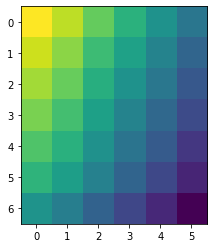

In [34]:
import matplotlib.pyplot as plt
plt.imshow(Grids.values)

In [35]:
best_threshold = 0.3
min_size = 1000

Score test data

In [36]:
df = pd.read_csv('../Data/stage_2_sample_submission.csv')
testID = df['ImageId'].values.tolist()
dataset_test = dataset(testID,images_dir,preprocessing=dataset_train.preprocessing)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=4)

In [37]:
yhat = predict(model,test_loader)

In [38]:
submit(df,yhat,best_threshold, min_size,\
       '../Submission/'+str(sz)+'_'+encoder_str+'_'+str(decoder_channels)+'_'+str(decoder_repeats)+'.csv')